# Imports and definitions

In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from numpy.random import random, poisson, choice
sys.path.append("C:/Users/jakob/Documents/MLandData/OtherFiles")
import Alexandria as lib
from Alexandria import printshape
from importnb import Notebook
with Notebook(): 
    from inferrence import infer



alpha = 0.9
beta = 0.2
gamma = 0.1
lambdas = np.array([1,5])

n = 10
T = 1000

In [3]:
C, z, X = simulate(n, T, 2, alpha, beta, gamma, lambdas)

C_pred = infer(X, alpha, beta, gamma, lambdas)[0]

print(np.mean(C_pred == C))

TypeError: _outer_dispatcher() got an unexpected keyword argument 'axis'

# Define the forward simulation

In [2]:
def simulate(n,T,C0 = 2, alpha = alpha, beta = beta, gamma = gamma, lambdas = lambdas):
    # Initialize the data arrays
    C = np.empty(T,dtype = int)
    z = np.empty((T,n),dtype = int)
    x = np.empty((T,n))

    # Define the probability for getting z = 1 given a C
    PZ1 = [1 - alpha, alpha, 0.5]

    # Define the Gamma matrix 
    Gamma = np.array([[1-gamma,0,gamma],[0,1-gamma,gamma],[beta/2,beta/2,1-beta]])

    # Loop over T iterations
    for t in range(T):
        # Find the C depending on the Gamma-matrix and the former C
        C[t] = choice([0,1,2], p = Gamma[C[t-1]]) if t > 0 else C0

        # With a probability depending on alpha and C, choose the Z's
        z[t] = random(n) <= PZ1[C[t]]

        # Draw the x's from a poisson depending on their z's and lambdas
        x[t] = poisson(lambdas[z[t]])

    return (C,z,x)


# Learning of parameters

In [3]:
clamp = lambda x, a, b: max(min(b,x),a)

def calc_parameters(X,z,C):
    
    lambda0 = np.mean(X[z == 0])
    lambda1 = np.mean(X[z == 1])
    lambdas = np.array([lambda0,lambda1])

    zc0 = z[C == 0]
    zc1 = z[C == 1]

    alphas = []
    if len(zc0.flatten()-1) > 0:
        alpha0 = 1-np.sum(zc0 == 1)/len(zc0.flatten()-1)
        alphas.append(alpha0)
    if len(zc1.flatten()-1) > 0:
        alpha1 = np.sum(zc1 == 1)/len(zc1.flatten()-1)
        alphas.append(alpha1)


    alpha_guess = clamp(np.mean(alphas),0.5,1)


    C00 = sum((C == 0)[1:] * (C == 0)[:-1])
    C10 = sum((C == 1)[1:] * (C == 0)[:-1])
    C20 = sum((C == 2)[1:] * (C == 0)[:-1])

    C01 = sum((C == 0)[1:] * (C == 1)[:-1])
    C11 = sum((C == 1)[1:] * (C == 1)[:-1])
    C21 = sum((C == 2)[1:] * (C == 1)[:-1])

    C02 = sum((C == 0)[1:] * (C == 2)[:-1])
    C12 = sum((C == 1)[1:] * (C == 2)[:-1])
    C22 = sum((C == 2)[1:] * (C == 2)[:-1])

    C0 = C00 + C10 + C20
    C1 = C01 + C11 + C21 
    C2 = C02 + C12 + C22

    gammas = []


    if C0 != 0:
        gamma2 = 1-C00/C0
        gammas.append(gamma2)
        gamma0 = C02/C0
        gammas.append(gamma0)
        # print(gamma0 + (1-gamma2))
    if C1 != 0:
        gamma3 = 1-C11/C1
        gammas.append(gamma3)
        gamma1 = C12/C1
        gammas.append(gamma1)
        # print(gamma1 + (1-gamma3))


    # print(gammas)
    gamma_guess = clamp(np.mean(gammas),0,1)
    
    betas = []
    if C2 > 0:
        b0 = 2*C20/C2
        betas.append(b0)
     
        b1 = 2*C21/C2
        betas.append(b1)

        b2 = 1 - C22/C2
        betas.append(b2)

    beta_guess = clamp(np.mean(betas),0,1)

    return (alpha_guess, beta_guess, gamma_guess, lambdas)




alpha = 0.9
beta = 0.5
gamma = 0.1
lambdas = np.array([1,5]).astype(float)

n, T = 10, 10000
C, z, X = simulate(n, T, 2, alpha, beta, gamma, lambdas)

alpha_guess, beta_guess, gamma_guess, lambda_guess = calc_parameters(X,z,C)


print(f"Alpha: {alpha:.3}", f"Alpha guess: {alpha_guess:.3}" )

print(f"Beta: {beta:.3}",f"Beta guess: {beta_guess:.3}")

print(f"Gamma: {gamma:.3}",f"Gamma guess: {gamma_guess:.3}")

print(f"Lambdas: ({lambdas[0]:.3},{lambdas[1]:.3})",f"Lambda guess': ({lambda_guess[0]:.3},{lambda_guess[1]:.3})")



Alpha: 0.9 Alpha guess: 0.903
Beta: 0.5 Beta guess: 0.508
Gamma: 0.1 Gamma guess: 0.0968
Lambdas: (1.0,5.0) Lambda guess': (0.994,4.99)


In [5]:
iterations = 100

n, T = 10, 10000



Cs, zs, Xs = np.empty((iterations,T)), np.empty((iterations,T,n)), np.empty((iterations,T,n))

alphas, betas, gammas, lambdass = [], [], [], []
for i in range(iterations):
    alpha = random()/2.01+0.501
    beta = random()/1.1+0.01
    gamma = random()/1.1 + 0.1
    lambdas = np.array([random()*10+0.01, random()*10+0.01])

    alphas.append(alpha)
    betas.append(beta)
    gammas.append(gamma)
    lambdass.append(lambdas)

    Cs[i], zs[i], Xs[i] = simulate(n, T, 2, alpha, beta, gamma, lambdas)


qual = np.empty((iterations,5))
print("Done simulating")

for i in range(iterations):
    alpha_guess, beta_guess, gamma_guess, lambda_guess = calc_parameters(Xs[i],zs[i],Cs[i])

    diffs = [(alphas[i]-alpha_guess)/alphas[i], (betas[i]-beta_guess)/alphas[i], (gammas[i]-gamma_guess)/gammas[i], (lambdass[i][0]-lambda_guess[0])/lambdass[i][0], (lambdass[i][1]-lambda_guess[1])/lambdass[i][1]]

    if  (gammas[i]-gamma_guess)/gammas[i] < -4:
        print(gammas[i],gamma_guess)
    qual[i] = np.array(diffs)





KeyboardInterrupt: 

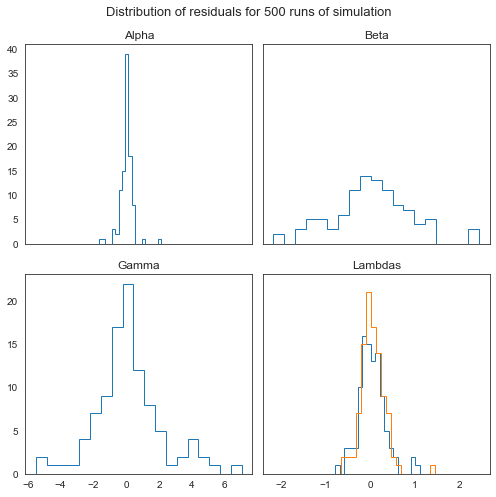

In [ ]:

fig, axs = plt.subplots(2,2,figsize = (7,7),sharex = 'col',sharey = 'row')

axs = axs.flatten()

names = ["Alpha", "Beta", "Gamma", "Lambdas"]
for i in range(5):
    axs[min(i,3)].hist(qual[:,i]*100,bins=19, histtype ="step")
    axs[min(i,3)].set_title(names[min(i,3)])

fig.suptitle("Distribution of residuals for 500 runs of simulation",fontsize = 13)

fig.tight_layout()
plt.show()

In [ ]:
axs[0]

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

# Hard EM 

In [5]:
def hard_EM(X,C,N = 1000):
    alpha = random()/2.01+0.5001
    beta = random()/101+0.001
    gamma = random()/100 + 0.001
    lambdas = np.array([1, 2])

    parameters = np.array([alpha, beta, gamma, lambdas])

    Cs = np.random.randint(0,3,X.shape[0])
    zs = np.random.randint(0,2,X.shape)
    C_last = np.random.randint(0,3,X.shape[0])

    for it in range(N):
        Cs, zs = infer(X, alpha, beta, gamma, lambdas,soft=False)

        parameters = calc_parameters(X, zs, Cs)

        # parameters = (parameters + _parameters)/2
        alpha, beta, gamma, lambdas = parameters

        
        # jit = 500
        # alpha += (random()-0.5)/jit
        # beta += (random()-0.5)/jit
        # gamma += (random()-0.5)/jit
        # lambdas += np.array([(random()-0.5)/jit,(random()-0.5)/jit])
        

        print(parameters)

        change = np.sum(C_last != Cs)
        print(f"Iteration {it}: Changed {change} Cs")

        print(f"Quality: {np.mean(Cs == C)}")

        if change == 0:
            break
        C_last = Cs.copy()
    
    parameters = {'alpha':alpha,'beta':beta,'gamma':gamma,'lambdas':lambdas}
    return (Cs, zs, parameters)


alpha = 0.9
beta = 0.6
gamma = 0.1
lambdas = np.array([1,5])

true_parameters = {'alpha':alpha,'beta':beta,'gamma':gamma,'lambdas':lambdas}
n, T = 10, int(1e4)
C, z, X = simulate(n,T,2,alpha,beta,gamma,lambdas)

Cs, zs, parameters = hard_EM(X,C)

print("Found:",parameters)
print("True: ",true_parameters)
print(f"{np.mean(C==Cs)*100:.3}% Correct")


C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


(0.699777965723388, 0.1086174651129334, 0.0891815407801198, array([0.51672872, 4.58624034]))
Iteration 0: Changed 6654 Cs
Quality: 0.4942
(0.7594796197392792, 0.4957482993197278, 0.07069684557477718, array([0.51672872, 4.58624034]))
Iteration 1: Changed 4458 Cs
Quality: 0.8354
(0.757569178781426, 0.799618320610687, 0.060597374253201074, array([0.51672872, 4.58624034]))
Iteration 2: Changed 802 Cs
Quality: 0.8706


KeyboardInterrupt: 

# Soft EM

In [5]:
def soft_EM(X,C,N = 1000):
    alpha = random()/2.01+0.5001
    beta = random()/101+0.001
    gamma = random()/100 + 0.001
    lambdas = np.array([1, 2])

    parameters = np.array([alpha, beta, gamma, lambdas])

    Cs = np.random.randint(0,3,X.shape[0])
    zs = np.random.randint(0,2,X.shape)
    C_last = np.random.randint(0,3,X.shape[0])

    for it in range(N):
        Cs, zs = infer(X, alpha, beta, gamma, lambdas,soft=True)

        parameters = calc_parameters(X, zs, Cs)

        # parameters = (parameters + _parameters)/2
        alpha, beta, gamma, lambdas = parameters

        print(parameters)

        change = np.sum(C_last != Cs)
        print(f"Iteration {it}: Changed {change} Cs")

        print(f"Quality: {np.mean(Cs == C)}")

        if change == 0:
            break
        C_last = Cs.copy()
    
    parameters = {'alpha':alpha,'beta':beta,'gamma':gamma,'lambdas':lambdas}
    return (Cs, zs, parameters)


alpha = 0.9
beta = 0.5
gamma = 0.1
lambdas = np.array([1,5])

true_parameters = {'alpha':alpha,'beta':beta,'gamma':gamma,'lambdas':lambdas}
n, T = 10, int(1e4)
C, z, X = simulate(n,T,2,alpha,beta,gamma,lambdas)

Cs, zs, parameters = soft_EM(X,C)

print("Found:",parameters)
print("True: ",true_parameters)
print(np.mean(C==Cs)*100,"% Correct")


C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [36]:
X.mean()

3.00636

# Plottings

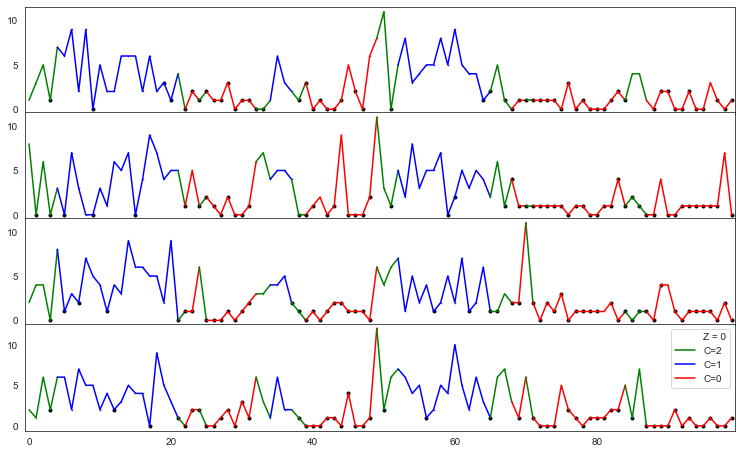

In [13]:
sns.set_style("white")

n, T = 4, 100

C, z, x = simulate(n,T,2)

def plot(x,z,C):
    fig, axs = plt.subplots(n,1,figsize = (10,6),sharex=True)

    x_split = [x[C == i] for i in range(3)]
    x_axis_split = [np.array([xx for xx in range(len(C))])[C == i] for i in range(3)]

    for nn in range(n):

        # axs[nn].plot(x[:,nn],alpha = 0.5)
        # axs[nn].plot(x[:,nn],'.',color= "black")
        cc = C[0]
        lt = 0
        made = np.zeros(3).astype(bool)
        made2 = False
        for t in range(1,T):
            axs[nn].plot([t],x[t,nn],'.',color=['red','blue','green'][cc], markersize = 1)
            if cc != C[t]:
                if not made[cc]:
                    made[cc] = True
                    axs[nn].plot([i for i in range(lt,t+1)], x[lt:t+1,nn],color =['red','blue','green'][cc], label = f"C={cc}")

                else:
                    axs[nn].plot([i for i in range(lt,t+1)], x[lt:t+1,nn],color =['red','blue','green'][cc] )
                cc = C[t]
                lt = t
            axs[nn].plot([t],x[t,nn],'.',color='black', alpha = [1,0][z[t,nn]], label = "Z = 0" if not made2 else None)
            made2 = True
            
        axs[nn].plot([i for i in range(lt,t+1)], x[lt:t+1,nn],color =['red','blue','green'][cc] )

        axs[nn].set_xlim(0-0.5,T-0.5)
        axs[nn].set_yticks([0,5,10])

    # sns.despine()
    plt.legend()
    plt.tight_layout(pad = -0.4)
    plt.show()


plot(x,z,C)

In [457]:

alpha = 0.9
beta = 0.5
gamma = 0.1
lambdas = np.array([1,5])

true_parameters = {'alpha':alpha,'beta':beta,'gamma':gamma,'lambdas':lambdas}
n, T = 50, 2000
C, z, x = simulate(n,T,2,alpha,beta,gamma,lambdas)

C_pred, z, parameters = hard_EM(x,C)




C:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


(0.6354092026694766, 0.07291666666666666, 0.08491477771920575, array([0.51540802, 4.52077918]))
Iteration 0: Changed 1336 Cs
Quality: 0.3885
(0.7533398600953037, 0.6006944444444445, 0.07220707360632733, array([0.51540802, 4.52077918]))
Iteration 1: Changed 1058 Cs
Quality: 0.8815
(0.750072877874109, 0.8401084010840109, 0.07472240060848694, array([0.51540802, 4.52077918]))
Iteration 2: Changed 119 Cs
Quality: 0.886
(0.7351869674185463, 1, 0.04061988861572424, array([0.51540802, 4.52077918]))
Iteration 3: Changed 123 Cs
Quality: 0.826
(0.7349651998203861, 1, 0.040611982615395725, array([0.51540802, 4.52077918]))
Iteration 4: Changed 4 Cs
Quality: 0.8255
(0.7349651998203861, 1, 0.040611982615395725, array([0.51540802, 4.52077918]))
Iteration 5: Changed 0 Cs
Quality: 0.8255


In [19]:
n = 10
C, z, X = simulate(n,int(1e2),2)


clf = LogisticRegression().fit([X.flatten() for x in range(len(C))],C)

T = int(1e2)

C, z, x = simulate(n,T,2)

C_pred = clf.predict([x.flatten()for i in range(T)])

np.mean(C==C_pred)


0.25

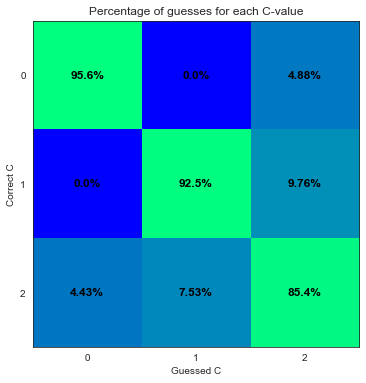

In [322]:
correct = array([array([sum(C_pred[C==j]==i)/sum(C==j) for j in range(3)]) for i in range(3)])*100


fig, ax = plt.subplots(1,1,figsize = (6,6))
img = ax.imshow(np.power(correct+1e-11,1/4), cmap = "winter")#,vmax = 8)

# fig.colorbar(img, ax = ax, fraction = 0.045,)
for (j,i), value in np.ndenumerate(correct):
    # ax.text(i,j,f"{value:.3}",ha='center',va='center',fontsize = 14)
    ax.text(i,j,f"{value:.3}%",ha='center',fontweight = "bold",va='center',fontsize = 12, color = "black",bbox=dict(facecolor='black', edgecolor='white',alpha = 0))

    # plt.text(i,j,label,ha='center',va='center')
    
ax.set_ylabel("Correct C")
ax.set_xlabel("Guessed C")

ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])

plt.title("Percentage of guesses for each C-value")

plt.show()
# correct

In [207]:
wrong = [np.mean(C[C==i] == C_pred[C==i]) for i in range(3)]

for i in range(3):
    print(f"Percentage of correct predictions for C={i}: {wrong[i]*100:.3}%")

np.mean(C==C_pred)

Percentage of correct predictions for C=0: 95.6%
Percentage of correct predictions for C=1: 92.5%
Percentage of correct predictions for C=2: 85.4%


0.9119

In [462]:
help(infer)

Help on function infer in module inferrence:

infer(X, alpha, beta, gamma, lambdas)



Quality: 0.893


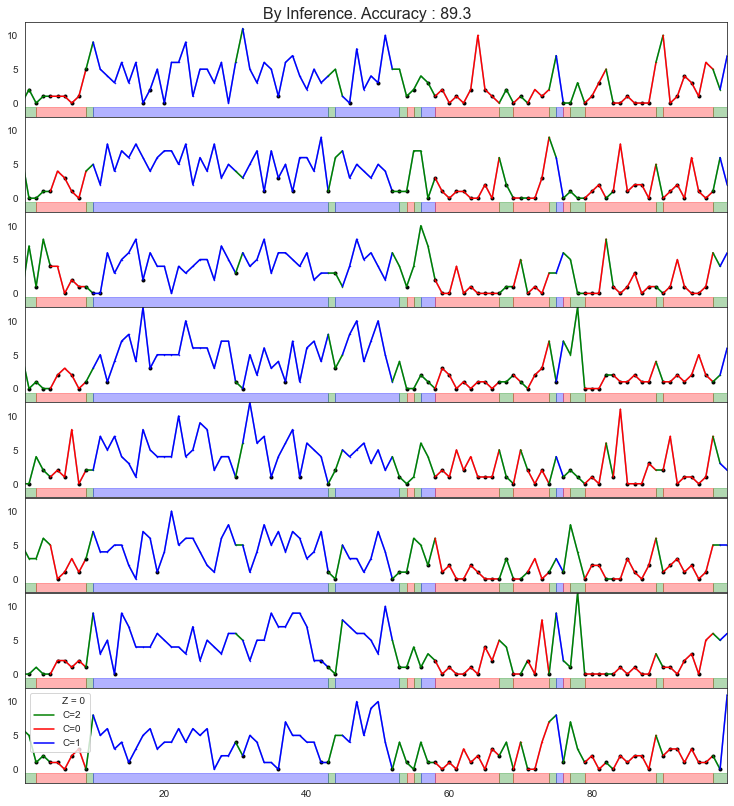

In [473]:
# T = 100
# n = 10

# alpha = 0.9
# beta = 0.5
# gamma = 0.1
# lambdas = np.array([1,5])

# n, T = 10, 2000

# C, z, x = simulate(n,T,2,alpha,beta,gamma,lambdas)

# C_pred, z_pred = infer(x,alpha,beta,gamma,lambdas)

print(f"Quality: {np.mean(C==C_pred)}")
# clf = LogisticRegression().fit(X,C)

# C, z, x = simulate(n,T,2)

# C_pred = clf.predict(x)



n = 8
T = 100

fig, axs = plt.subplots(n,1,figsize = (10,11),sharex=True)

x_split = [x[C == i] for i in range(3)]
x_axis_split = [np.array([xx for xx in range(len(C))])[C == i] for i in range(3)]

p = 0.1

for nn in range(n):
    axs[nn].plot(x[:,nn],alpha = 0.5)
    cc = C[0]
    cc_pred = C_pred[0]
    lt = 0
    lt_pred = 0

    made = np.zeros(3)
    made2 = False

    for t in range(1,T):
        axs[nn].plot([t],x[t,nn],'.',color=['red','blue','green'][cc], markersize = 1)
        if cc != C[t]:
            xxx = [i for i in range(lt,t+1)]

            if not made[cc]:
                made[cc] = True
                axs[nn].plot(xxx, x[lt:t+1,nn],color =['red','blue','green'][cc], label = f"C={cc}")

            else:
                axs[nn].plot(xxx, x[lt:t+1,nn],color =['red','blue','green'][cc] )
            cc = C[t]
            lt = t

        if cc_pred != C_pred[t]:
            axs[nn].axvspan(lt_pred, t, ymin = 0, ymax = p,alpha=0.3, color=['red','blue','green'][cc_pred])
            # axs[nn].axvspan(lt_pred+0.5, t+0.5, ymin = 0, ymax = 1,alpha=0.05, color=['red','blue','green'][cc_pred])
            # axs[nn].fill_between([i for i in range(lt_pred,t+1)],x[lt_pred:t+1,nn],color = ['red','blue','green'][cc_pred],alpha = 0.2)
            cc_pred = C_pred[t]
            lt_pred = t
        
        axs[nn].plot([t],x[t,nn],'.',color='black', alpha = [1,0][z[t,nn]], label = "Z = 0" if not made2 else None)
        made2 = True

    # axs[nn].plot([i for i in range(lt,t+1)],x[lt:t+1,nn],'.',color=['red','blue','green'][cc])
    axs[nn].plot([i for i in range(lt,t+1)], x[lt:t+1,nn],color =['red','blue','green'][cc], markersize = 13)
    axs[nn].axvspan(lt_pred,T, ymin = 0, ymax = p, alpha=0.3, color=['blue','red','green'][cc_pred])


    axs[nn].set_xlim(0+0.5,T-1)
    axs[nn].set_ylim(-2,12)

    axs[nn].set_yticks([0,5,10])

plt.legend()
fig.suptitle(f"By Inference. Accuracy : {np.mean(C_pred == C)*100:.3}",fontsize = 16, y = 1)#",fontsize=16)
plt.tight_layout(pad = 0)
plt.show()

Learning of the parameters:

In [2]:
n = 10
T = 2*10000

C, z, X = simulate(n,T,0)


alpha_guess, beta_guess, gamma_guess, lambda_guess = calc_parameters(X,z,C)

print("Alpha:", alpha, "Alpha guess:", alpha_guess)

print("Beta:", beta, "Beta guess:", beta_guess)

print("Gamma:", gamma, "Gamma guess:", gamma_guess)

print("Lambdas:", lambdas, "Lambda guess':", lambda_guess)



NameError: name 'simulate' is not defined

In [20]:
from sklearn.model_selection import GridSearchCV


X = np.genfromtxt("Ex_1.csv",skip_header=1,delimiter=",")[:,1:]

c, z = infer(X,alpha,beta,gamma,lambdas)


poisson_dist = lambda x, _lambda: np.power(_lambda,x)*np.exp(-_lambda)/np.math.factorial(x) 


for xx,zz in zip(X,z):
    # printshape(xx)

    ans = [poisson_dist(a,lambdas[b]) for a,b in zip(xx,zz)]
    print(ans)
    print(xx,zz)
    break
    
# poisson_dist(X,z)
# printshape(X)


[0.24217884813151072, 0.17657098540009095, 0.17657098540009095, 0.8123973365604042, 0.22144292978226052, 0.15186185187792253, 0.8123973365604042, 0.0015600237902382449]
[2. 1. 1. 0. 3. 4. 0. 9.] [1 1 1 0 1 1 0 1]
